# Installing sentence-transformers and Loading raw data

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 2.1MB 7.5MB/s 
     |████████████████████████████████| 1.2MB 39.9MB/s 
     |████████████████████████████████| 901kB 36.9MB/s 
     |████████████████████████████████| 3.3MB 41.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.4-cp37-none-any.whl size=114307 sha256=2a06ef3c4c1ff178486d51cd2f2bd1295408c43e5374b2e2a1c2ffb952f5e6fc
  Stored in directory: /root/.cache/pip/wheels/26/ea/89/d0d2e013d951b6d23270aa9ca4018b82632ab7cd933c331316
Successfully built sentence-transformers


In [ ]:
import pandas as pd

In [ ]:
url = 'https://raw.githubusercontent.com/kazzyabe/Bert-based_Explanation/master/bert-based_explanation/data_bert_abstract.csv'

In [ ]:
data = pd.read_csv(url)

In [ ]:
data

,query,citation,decision
0,Lexicon-Based Methods for Sentiment Analysis ...,Amazon Mechanical Turk for Subjectivity Word ...,1
1,Lexicon-Based Methods for Sentiment Analysis ...,Mining WordNet for Fuzzy Sentiment: Sentimen...,1
2,Lexicon-Based Methods for Sentiment Analysis ...,When Specialists and Generalists Work Togethe...,0
3,Lexicon-Based Methods for Sentiment Analysis ...,Distilling Opinion in Discourse: A Preliminar...,0
4,Lexicon-Based Methods for Sentiment Analysis ...,SENTIWORDNET 3.0: An Enhanced Lexical Resourc...,1
...,...,...,...
95,Learning Subjective Language Theresa Wilson ...,Similarity-Based Estimation of Word Cooccurre...,1
96,Learning Subjective Language Theresa Wilson ...,Recognizing Expressions of Commonsense Psycho...,1
97,Learning Subjective Language Theresa Wilson ...,Automatic Detection of Text Genre Xerox Palo...,0
98,Learning Subjective Language Theresa Wilson ...,Building a Large Annotated Corpus of English:...,1


In [ ]:
test = data.loc(0)

In [ ]:
test[0]

query        Lexicon-Based Methods for Sentiment Analysis ...
citation     Amazon Mechanical Turk for Subjectivity Word ...
decision                                                    1
Name: 0, dtype: object

# Bert Embeddings and similarity

In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [ ]:
emb1 = model.encode(test[0]['query'])

In [ ]:
emb1

array([-7.92179629e-02,  1.43447638e-01,  3.48825045e-02,  1.00453429e-01,
       -2.44085819e-01,  2.64541596e-01,  6.26787618e-02,  1.24122724e-01,
        2.38916725e-01,  1.40800819e-01,  9.28694531e-02, -1.53008431e-01,
       -5.04332073e-02, -2.08792642e-01,  4.84189630e-01, -5.24679124e-01,
       -2.48965308e-01,  2.66872108e-01,  2.65130758e-01, -3.62376630e-01,
       -2.03113183e-01, -2.58812487e-01, -5.84234774e-01, -5.76784275e-03,
        1.56039983e-01,  4.26899791e-01,  1.20357268e-01,  2.96965033e-01,
       -3.75888169e-01,  3.25945318e-01, -1.33425251e-01, -8.19215328e-02,
       -2.28072256e-01,  3.41555700e-02, -5.05156875e-01, -1.31687149e-01,
        1.43502146e-01,  2.59144515e-01, -4.44411337e-01,  1.41337395e-01,
        2.86842287e-01,  5.62809527e-01, -3.59770894e-01,  4.68921244e-01,
       -1.23148570e-02, -1.36102557e-01, -7.73691654e-01, -1.07130551e+00,
        2.52524726e-02, -1.10799976e-01,  4.01372790e-01,  1.21481717e-01,
        1.39492363e-01,  

In [ ]:
emb2 = model.encode(test[0]['citation'])

In [ ]:
cos_sim = util.pytorch_cos_sim(emb1, emb2)
print("Cosine-Similarity:", cos_sim)

Cosine-Similarity: tensor([[0.3066]])


In [ ]:
print("Cosine-Similarity:", cos_sim.item())

Cosine-Similarity: 0.30656397342681885


In [ ]:
def cos_sim(d):
  emb1 = model.encode(d['query'])
  emb2 = model.encode(d['citation'])
  cos_sim = util.pytorch_cos_sim(emb1, emb2)
  return cos_sim.item()

In [ ]:
data['cos_sim'] = data.apply(lambda d: cos_sim(d), axis=1)

In [ ]:
data['cos_sim']

0     0.306564
1     0.526880
2     0.316767
3     0.386031
4     0.419494
        ...   
95    0.537981
96    0.591112
97    0.461797
98    0.376774
99    0.433764
Name: cos_sim, Length: 100, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x = data['cos_sim']
y = data['decision']

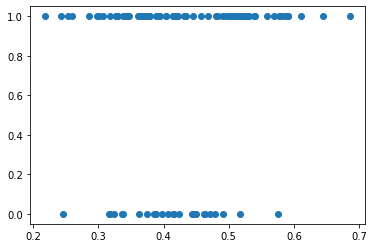

In [ ]:
plt.scatter(x,y)

In [ ]:
data.to_csv('cos_sim.csv', index=False)

## Downloading 

In [ ]:
from google.colab import files
files.download("cos_sim.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ROC for cos_sim

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [3]:
cos_sim = "https://raw.githubusercontent.com/kazzyabe/Bert-based_Explanation/master/bert-based_explanation/cos_sim.csv"
data = pd.read_csv(cos_sim)
X = data['cos_sim']
y = data['decision']

In [4]:
# Binarize the output
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

In [5]:
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
# n_samples, n_features = X.shape
n_samples = 100
n_features = 1
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

In [7]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [8]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_test[:], y_score[:])
roc_auc[0] = auc(fpr[0], tpr[0])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

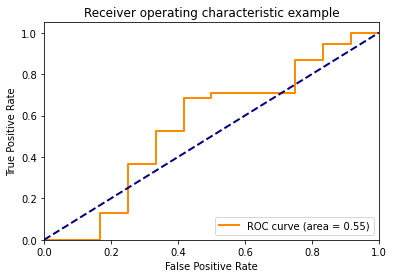

In [9]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Bert Classifier